In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

# **IMPORTING THE DATASET**

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:11<00:00, 157MB/s]
100% 1.04G/1.04G [00:11<00:00, 101MB/s]


In [ ]:
import zipfile
zip= zipfile.ZipFile("/content/flickr8k.zip","r")
zip.extractall("/content")
zip.close()

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **READING AND VISUALIZING THE INPUT DATA**

In [ ]:
image_path = '/content/Images'

In [ ]:
data = pd.read_csv("/content/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

In [ ]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

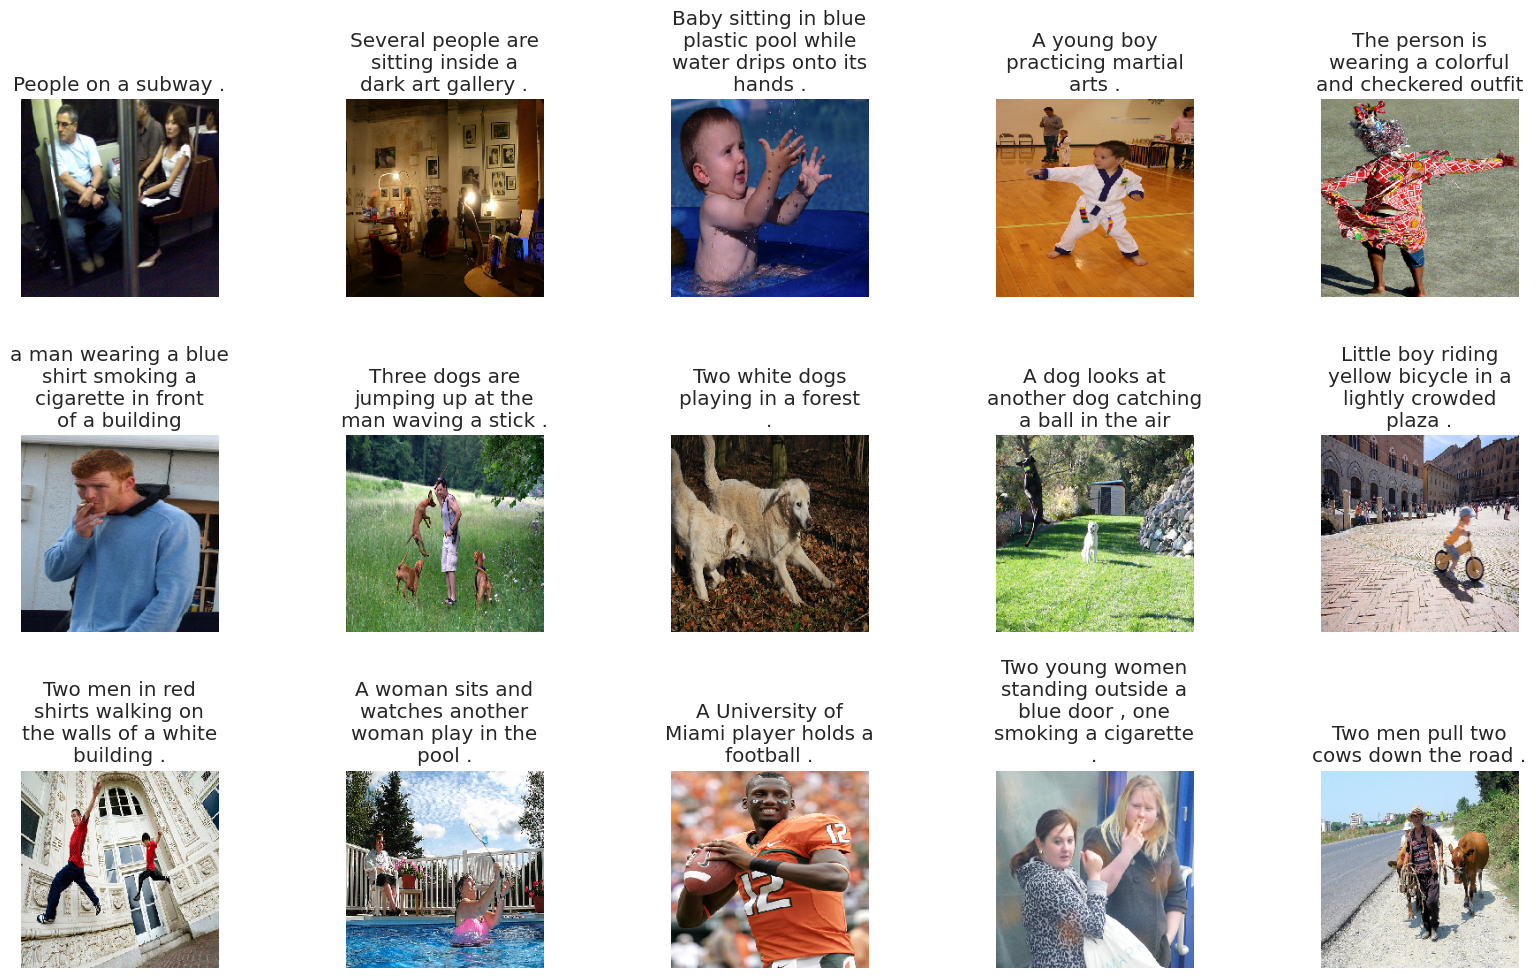

In [ ]:
display_images(data.sample(15))

# **Text Preprocessing**

* Convert sentences into lowercase
*   Remove special characters and numbers present in the text

* Remove extra spaces
* Remove single characters
* Add a starting and an ending tag to the sentences to indicate the beginning
   and the ending of a sentence






In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# **Tokenization**

mapping each word of the vocabulary with a unique index value

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **Feature Extraction**

We use a pre-trained architecture like DenseNet201 to extract features from our images. Reusing the pre-trained weights will save us a lot of time and resources

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 1s 0us/step


100%|██████████| 8091/8091 [31:12<00:00,  4.32it/s]


# **Custom Data Generation**

This amount of data for 8091 images is not possible to hold into memory so we will be using a generator method that will yield batches.

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)# shuffle the rows of the dataframe

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:] #obtains the selectd rows from the df.
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0] #obtains feature vector of each image

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0] #encode the seq (each word is assigned an index)

                for i in range(1,len(seq)): #split the seq in X2 and y pairs(i/p o/p)
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]#so that i/p o/p seq have same length
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0] #one-hot representation
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#x1 is the feature vector,x2 is i/p text seq, y is op text seq that the model has to predixt
        return X1, X2, y

# Model

In [ ]:
input1 = Input(shape=(1920,))#feature vector
input2 = Input(shape=(max_length,))#i/p seq
#img
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)
#text seq
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
#merge both
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)
#final model
caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# **Adding Callbacks**

* Early Stopping: allows us to monitor our metrics, and stop model training when it stops improving.
*	Model Checkpoint: This callback allows us to save the model regularly during training. This is especially useful when training deep learning models which take a long time to train.
*	ReduceLROnPlateau: This callback is used when you want to change the learning rate when the metrics have stopped improving


In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

# **Model Training**

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1146
Epoch 1: val_loss improved from inf to 4.21604, saving model to model.h5
537/537 [==============================] - 3425s 6s/step - loss: 5.1146 - val_loss: 4.2160 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.1703
Epoch 2: val_loss improved from 4.21604 to 3.90823, saving model to model.h5
537/537 [==============================] - 761s 1s/step - loss: 4.1703 - val_loss: 3.9082 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.9067
Epoch 3: val_loss improved from 3.90823 to 3.77006, saving model to model.h5
537/537 [==============================] - 746s 1s/step - loss: 3.9067 - val_loss: 3.7701 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.7488
Epoch 4: val_loss improved from 3.77006 to 3.70559, saving model to model.h5
537/537 [==============================] - 741s 1s/step - loss: 3.7488 - val_l

# **Caption Generation**

pre process the test data that we have to predict

In [ ]:
def idx_to_word(integer,tokenizer):      #convert index to word

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]  #get feature vector of img
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0] #encode the seq
        sequence = pad_sequences([sequence], max_length) #pad the seq

        y_pred = model.predict([feature,sequence]) # predict
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = test.sample(15)#test data 15 random images
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows(): #load the data

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features) #predict
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 22ms/step


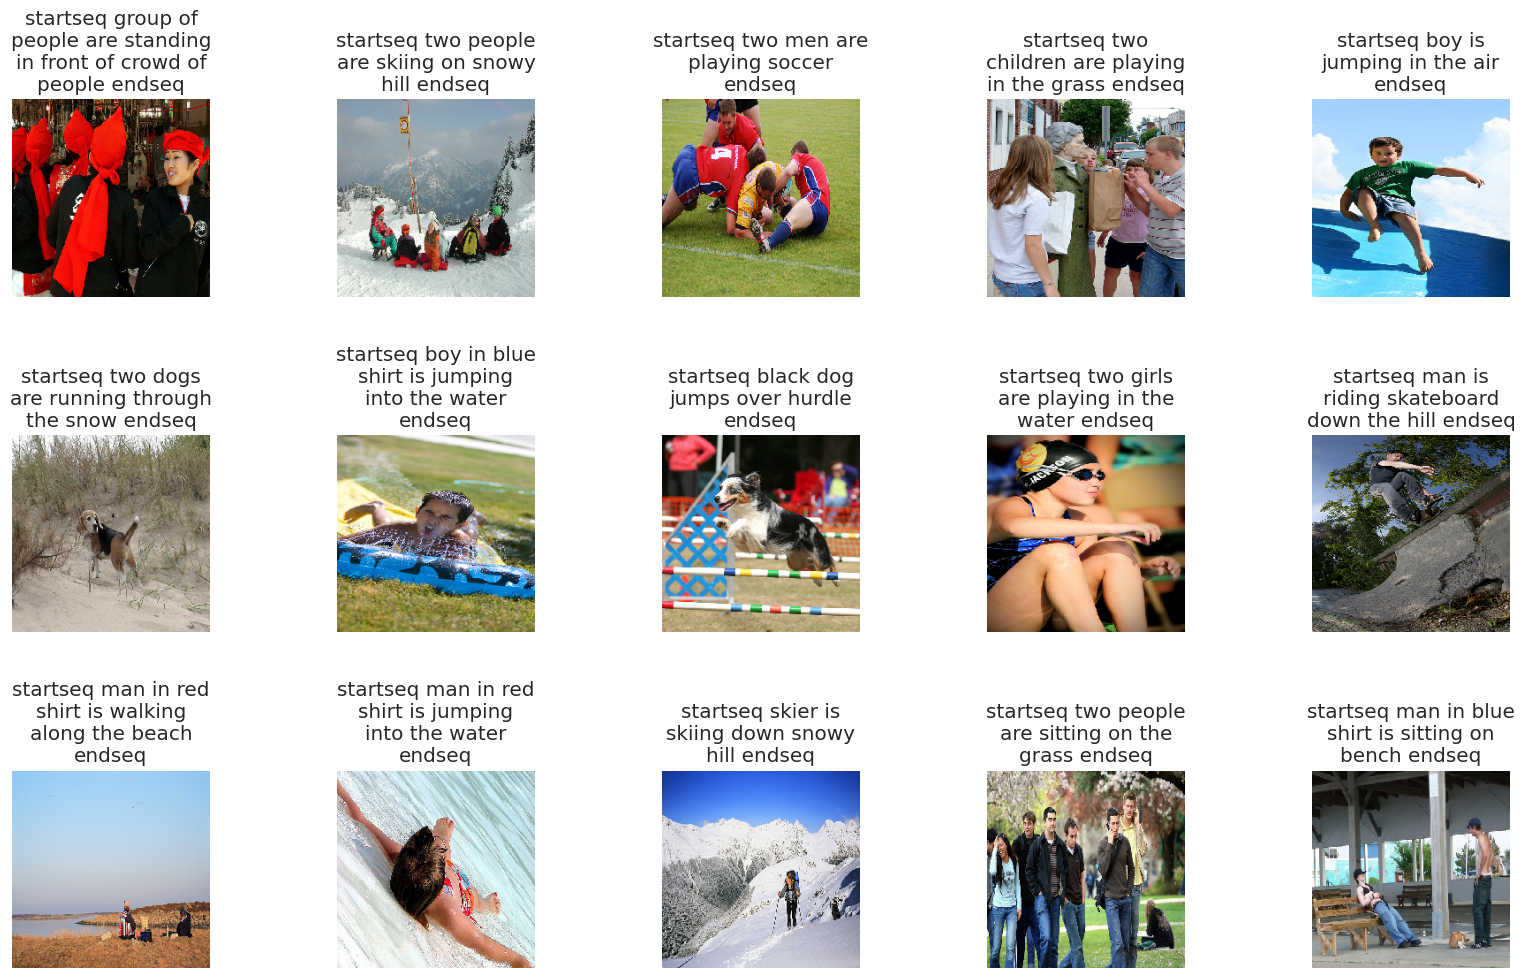

In [ ]:
display_images(samples)# display